In [1]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_validation import KFold, train_test_split, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from mhcflurry.amino_acid import common_amino_acids
from mhcflurry import dataset
from mhcflurry.dataset import Dataset
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

Using Theano backend.


In [2]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")

df['log_meas']=1-np.log(df['meas'])/math.log(50000)
df['peptide_length'] = df['sequence'].str.len()


max_len=df['sequence'].str.len().max()
n_peptides = df['sequence'].count()

def amino_acid_hotshot_encoding(s):
    return common_amino_acids.hotshot_encoding([s],len(s)).flatten().astype(int)
df['hotshot_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_hotshot_encoding(seq))

def amino_acid_index_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df['index_encoded_peptides'] = df.sequence.apply(lambda seq: amino_acid_index_encoding(seq, max_len))

def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000)

df['affinity_label'] = affinity_label(df['log_meas'])
df_h = df[df['mhc']=='HLA-A-0201'][['hotshot_encoded_peptides','index_encoded_peptides','log_meas','peptide_length']]
X = np.array(list(df_h['index_encoded_peptides']))
y = np.array(list(df_h['log_meas']))
y[y<0]=0

In [3]:
folds = 3
batch_size_nn = 16
batch_size_lstm = 16
hidden = 50
dropout_probability = 0.25
embedding_dropout = 0.25
n_epochs = 100
epoch = 0


train_lstm111_aucs = np.zeros((folds,n_epochs))
test_lstm111_aucs = np.zeros((folds,n_epochs))


train_lstm111ffn_aucs = np.zeros((folds,n_epochs))
test_lstm111ffn_aucs = np.zeros((folds,n_epochs))


for i, (train_idx, test_idx) in enumerate(KFold(len(df_h),folds, shuffle=True)):
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, dropout=embedding_dropout, mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    pre_output = Dense(10, activation = 'sigmoid')(after_dp)
    output = Dense(1, activation = 'sigmoid')(pre_output)
    lstm111ffn = Model(input = sequence, output = output)
    
    lstm111ffn.compile(optimizer = 'adam', loss='mean_squared_error')
    
    sequence = Input( shape= (26, ),dtype='int32')
    embedded = Embedding(input_dim = 21, input_length = 26, output_dim= 32, dropout=embedding_dropout,mask_zero = True)(sequence)
    forwards = LSTM(hidden, dropout_W = 0.5, dropout_U = 0.5)(embedded)
    backwards = LSTM(hidden, dropout_W = 0.5,dropout_U = 0.5, go_backwards=True)(embedded)

    merged = merge([forwards, backwards], mode = 'concat', concat_axis=-1)
    after_dp = Dropout(dropout_probability)(merged)
    output = Dense(1, activation = 'sigmoid')(after_dp)
    lstm111 = Model(input = sequence, output = output)
    
    lstm111.compile(optimizer = 'adam', loss='mean_squared_error')
    
    for epoch in range(n_epochs):
        
        
        #lstm111ffn
        lstm111ffn.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm111ffn_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm111ffn.predict(X[train_idx]))
        test_lstm111ffn_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm111ffn.predict(X[test_idx]))
        
        train_lstm111ffn_aucs[i][epoch]=train_lstm111ffn_auc
        test_lstm111ffn_aucs[i][epoch]=test_lstm111ffn_auc
        
        #lstm111 
        lstm111.fit(X[train_idx],y[train_idx], batch_size = batch_size_lstm, nb_epoch=1)
    
        train_lstm111_auc = roc_auc_score(measured_affinity_less_than(y[train_idx],500),lstm111.predict(X[train_idx]))
        test_lstm111_auc = roc_auc_score(measured_affinity_less_than(y[test_idx],500),lstm111.predict(X[test_idx]))
        
        train_lstm111_aucs[i][epoch]=train_lstm111_auc
        test_lstm111_aucs[i][epoch]=test_lstm111_auc
        
        print(test_lstm111ffn_auc, test_lstm111_auc, epoch, i)


train_lstm111ffn_aucs_mean = np.mean(train_lstm111ffn_aucs, axis=0)
test_lstm111ffn_aucs_mean = np.mean(test_lstm111ffn_aucs, axis=0)


train_lstm111_aucs_mean = np.mean(train_lstm111_aucs, axis=0)
test_lstm111_aucs_mean = np.mean(test_lstm111_aucs, axis=0)

Epoch 1/1
6376/6376 [==============================] - 11s - loss: 0.0729    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0760    
0.849808122745 0.834056349078 0 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0661    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0672    
0.851786801472 0.846946826393 1 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0639    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0649    
0.855459271789 0.852939662502 2 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0620    
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0632    
0.862216244424 0.869198198022 3 0
Epoch 1/1
6376/6376 [==============================] - 12s - loss: 0.0610    
Epoch 1/1
6376/6376 [==============================] - 13s - loss: 0.0593    
0.875088528012 0.894233209853 4 0
Epoch 1/1
6376/6376 [=============================

KeyboardInterrupt: 

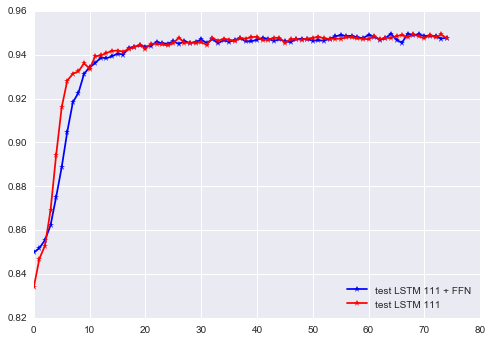

In [4]:
plt.plot( np.arange(0,75,1), test_lstm111ffn_aucs[0,0:75],color='b',marker='*', linestyle='-', label ="test LSTM 111 + FFN")
plt.plot( np.arange(0,75,1), test_lstm111_aucs[0,0:75],color='r',marker='*', linestyle='-', label ="test LSTM 111")
plt.legend(loc=4)

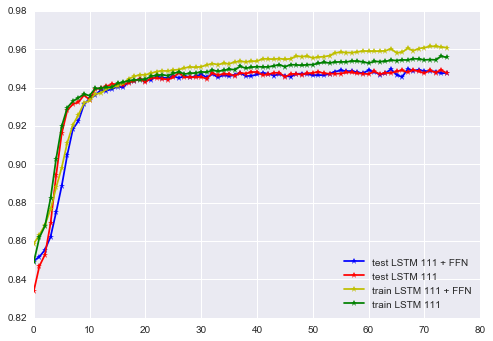

In [5]:
plt.plot( np.arange(0,75,1), test_lstm111ffn_aucs[0,0:75],color='b',marker='*', linestyle='-', label ="test LSTM 111 + FFN")
plt.plot( np.arange(0,75,1), test_lstm111_aucs[0,0:75],color='r',marker='*', linestyle='-', label ="test LSTM 111")
plt.plot( np.arange(0,75,1), train_lstm111ffn_aucs[0,0:75],color='y',marker='*', linestyle='-', label ="train LSTM 111 + FFN")
plt.plot( np.arange(0,75,1), train_lstm111_aucs[0,0:75],color='g',marker='*', linestyle='-', label ="train LSTM 111")
plt.legend(loc=4)